In [1]:
## Please remember to update "COT.py" to the newest version

import sys
sys.path.append("./")

from COT import COT

In [2]:
## Download GSE28490

import GEOparse

gse = GEOparse.get_GEO(geo="GSE28490", destdir="./", silent=True)

C:\Users\Minta\Anaconda3\lib\site-packages\GEOparse\GEOparse.py:110: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return parse_GSE(filepath, open_kwargs=open_kwargs)


In [3]:
## Select needed cell types

cellTypes = {"Neutrophils": [], "NK": [], "CD19+ B": [], "CD8+ T": [], "CD14+ monocytes": []}

sampleType = [] # cell type labels
for cell in cellTypes:
    for gsm in gse.phenotype_data.index.values:
        if cell in gse.phenotype_data["source_name_ch1"][gsm]:
            cellTypes[cell].append(gsm)
            sampleType.append(cell)
            
samples = [] # sample ID
for cell in cellTypes:
    samples = samples + cellTypes[cell]   
    
data = gse.pivot_samples('VALUE')[samples] # selected raw data

In [4]:
## Run COT

cot = COT(df_raw=data, logarithmic_data=True)
cot.generate_subtype_means(sampleType)
cot.generate_cos_values()

COT: package initiated.
COT: subtype means generated.


C:\Users\Minta\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


COT: cos values generated.


In [5]:
## Estimate p-value

cot.estimate_p_values()

COT: estimating p-values ...
Iteration 1: 19.9223 seconds
Iteration 2: 12.2734 seconds
Iteration 3: 13.1726 seconds
Iteration 4: 13.2597 seconds
Iteration 5: 10.8018 seconds
Iteration 6: 10.6564 seconds
COT: p-values estimated.


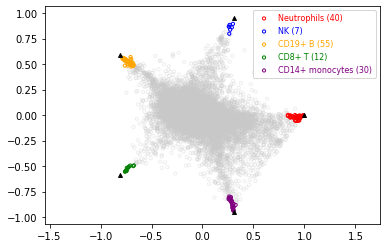

In [6]:
## Plot the markers on the simplex

cot.obtain_subtype_markers(top=144)
cot.plot_simplex()

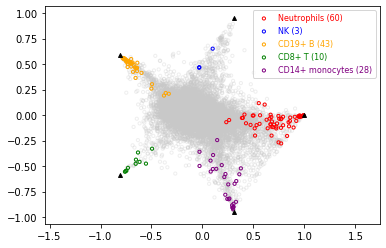

In [7]:
## OVO t-stats

import numpy as np
import pandas as pd

def generate_ovo_tstats(df, map_subtypes):
    df_tmp = df.copy()
    df_tmp = np.log2(df_tmp)
    
    mean = df_tmp.apply(lambda x: np.array([np.mean(x[col]) for col in map_subtypes.values()]), axis=1)
    var = df_tmp.apply(lambda x: np.array([np.var(x[col], ddof=1) for col in map_subtypes.values()]), axis=1)
    n = df_tmp.apply(lambda x: np.array([len(col) for col in map_subtypes.values()]), axis=1)
    
    idx = mean.apply(lambda x: np.argmax(x))
    ovo = pd.DataFrame({'mean': mean, 'n': n, 'var': var, 'idx': idx}) \
            .apply(lambda x: (x['mean'][x['idx']] - x['mean']) / np.sqrt(x['var'][x['idx']] / x['n'][x['idx']] + x['var'] / x['n']), axis=1) \
            .apply(lambda x: np.sort(x)).apply(lambda x: x[1])
    
    subtype = idx.apply(lambda x: list(map_subtypes.keys())[x])
    df_ovo = pd.DataFrame({'ovo': ovo, 'subtype': subtype}, index=df.index)
    
    return df_ovo

def generate_ovo_markers(df, map_subtypes, top=None):
    markers = {i: [] for i in map_subtypes.keys()}
    
    df_select = df.loc[df['ovo'].sort_values(ascending=False)[:top].index]
    for subtype in markers.keys():
        markers[subtype] = df_select[df_select['subtype'] == subtype].index
    
    return markers

ovo = COT(df_raw=data, logarithmic_data=True, silent=True)
ovo.generate_subtype_means(sampleType)
ovo.df_ovo = generate_ovo_tstats(ovo.df_raw, cellTypes)
ovo.markers = generate_ovo_markers(ovo.df_ovo, cellTypes, top=144)
ovo.plot_simplex()

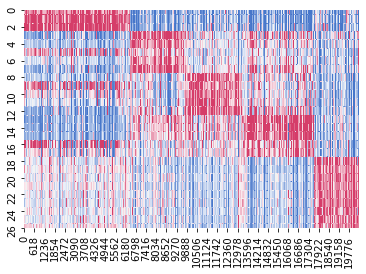

In [9]:
## plot heatmap

import seaborn as sns

order = {v: i for i, v in enumerate(cot.df_mean.columns)}
index = cot.df_cos['subtype'].map(order).sort_values().index
data = cot.df_raw.loc[index].apply(lambda x: x / np.sum(x), axis=1).values.T

sns.heatmap(data, vmin=0.01, vmax=0.06, cbar=False, cmap=sns.diverging_palette(255, 0, n=100))